In [33]:
# utils
def BinarySearch(x, arr):
    mid = len(arr) // 2
    low = 0
    high = len(arr) - 1
    
    while arr[mid] != x and low <= high:
        if x > arr[mid]:
            low = mid + 1
        else:
            high = mid - 1
        mid = (low + high) // 2
    
    return mid


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log, exp, sin, cos, sqrt

In [35]:
# Рассчёт значения из прошлого шагом плотной выдачи
def phi(x, X, Y, K, b, h, x0, past):
    if x < x0:
        return past(x)
    if x in X:
        return Y[X.index(x)]

    i_xm = BinarySearch(x, X)
    
    theta = (x - X[i_xm]) / h

    if(i_xm > len(K) - 1):
        return past(x)
    
    return Y[i_xm] + h * sum([K[i_xm][i] * b[i](theta) for i in range(len(b))])


In [36]:
# шаг явного метода
def stepExplicit(method, problem, X, Y, h, K):
    x = X[-1]
    y = Y[-1]
    z = problem.Z(X, Y, K, method.B, h, problem.x0, problem.past) if problem.Z else None

    # K_i = f(x_0 + h * c_i, y_0 + h * sum( K_j * A_ij ) ) i < j < N
    _K = []
    for i in range(method.N):
        dy = h * sum([_K[j] * method.A[i][j] for j in range(len(_K))])
        _K.append( problem.f(x + method.c[i] * h, y + dy, z) )
        
    return x + h, y + h * sum([_K[i] * method.B[i](1) for i in range(method.N)]), _K

# шаг неявного метода
def stepImplicit(method, problem, X, Y, h, K):
    x = X[-1]
    y = Y[-1]
    z = problem.Z(X, Y, K, method.B, h, problem.x0, problem.past) if problem.Z else None

    Zk = [problem.f(x, y, z)] * method.N
    J = problem.fprime(x, y, z)
    N = [
        [
            (1 if i == j else 0) - h * method.A[i][j] * J
            for j in range(method.N)
        ]
        for i in range(method.N)
        # [1 - h * method.A[0][0] * J, - h * method.A[0][1] * J],
        # [ - h * method.A[1][0] * J, 1 - h * method.A[1][1] * J]
    ]
    for _ in range(5):
        Fzk = [
            problem.f(x + method.c[i], y + Zk[i], z)
            for i in range(method.N)
        ]
        nb = [
            -Zk[i] + h * sum([
                method.A[i][j] * Fzk[j]
                for j in range(method.N)
            ])
            for i in range(method.N)
        ]
        Zk = np.linalg.solve(N, nb)

    return x + h, y + h * sum([Zk[i] * method.B[i](1) for i in range(method.N)]), Zk

def stepImplicitOld(method, problem, X, Y, h, K):
    x = X[-1]
    y = Y[-1]
    z = problem.Z(X, Y, K, method.B, h, problem.x0, problem.past) if problem.Z else None

    _K = [0] * method.N
    for _ in range(5):
        __K = []
        # K_i = f(x_0 + h * c_i, y_0 + h * sum( K_j * A_ij ) ) i,j < N
        for i in range(method.N):
            dy = h * sum([_K[j] * method.A[i][j] for j in range(method.N)])
            __K.append( problem.f(x + method.c[i] * h, y + dy, z) )
        _K = __K

    return x + h, y + h * sum([_K[i] * method.B[i](1) for i in range(method.N)]), _K

In [37]:


class Method:
    def __init__(self, A, B, c, implict=False, addStep=False):
        self.A = A
        self.B = B
        self.c = c
        self.N = len(c)
        self.implicit = implict
        self.step = stepImplicitOld if implict else stepExplicit
        self.addStep = addStep

In [38]:
class Problem:
    def __init__(self, x0, x1, y0, f, trueSol, fprime=None, past=None, Z=None):
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.f = f
        self.trueSol = trueSol
        self.fprime = fprime
        self.past = past
        self.Z = Z

In [39]:
def getSolution(method, problem, h):
    x, y, k = problem.x0, problem.y0, []
    X = [x]
    Y = [y]
    K = k
    while X[-1] != problem.x1:
        if X[-1] + h > problem.x1:
            x, y, k = method.step(method, problem, X, Y, problem.x1 - X[-1], K)
        else:
            x, y, k = method.step(method, problem, X, Y, h, K)
        X.append(x)
        Y.append(y)
        K.append(k)
        
    return X, Y

In [40]:
def getGraph(method, problem, h, customX=None):
    x, y = getSolution(method, problem, h)

    X = customX if customX else x

    fig, ax = plt.subplots()
    trueSolDelay = [problem.trueSol(x) for x in X]

    ax.plot(x, y, 'r')
    ax.plot(X, trueSolDelay, 'g:')
    ax.set_xlabel('y - solution')
    ax.set_ylabel('x - time')
    ax.grid(True)

    print(f'Err = {abs(y[-1] - trueSolDelay[-1])}')

In [41]:
def getGraph2Pow(method, problem, p=3, endPower=10, Q=2):
    N = []
    H = []
    for k in range(1, endPower):
        h = 1 / (Q ** k)
        H.append(np.log10(h))
        x, y = getSolution(method, problem, h)
        trueY = [problem.trueSol(x) for x in x]
        N.append(np.log10( abs(trueY[-1] - y[-1]) ))

    y = N[0]+p*(H-H[0])

    _, ax = plt.subplots()
    ax.set_title(f'P = {p}')
    ax.set_xlabel('H - step size')
    ax.set_ylabel('|E| - global error')
    ax.plot(H, N, color='b', linestyle='--')
    ax.plot(H, y, 'r')
    ax.grid(True)

In [42]:
# Функция приближения значения из прошлого
def Z(X, Y, K, B, h, x0, past):
    def z(x):
        return phi(x, X, Y, K, B, h, x0, past)
    
    return z

In [43]:
# Задача 0
def solution0(x):
    return sin(x) + cos(x)

H_0 = 0.3 

def f0(x, y, z):
    return cos(x) - sin(x)

problem0 = Problem(x0 = 0, x1 = 5, y0 = 1, f = f0, trueSol = solution0)

In [44]:
# Задача 1
def solution1(x):
    if x <= 0:
        return 1
    if x <= 1:
        return 1 - x
    if x <= 2:
        return 1 - x + (x - 1)**2 / 2
    if x <= 3:
        return 1 - x + (x - 1)**2 / 2 - (x - 2)**3 / 6
    if x <= 4:
        return 1 - x + (x - 1)**2 / 2 - (x - 2)**3 / 6 + (x - 3)**4 / 24
    if x <= 5:
        return 1 - x + (x - 1)**2 / 2 - (x - 2)**3 / 6 + (x - 3)**4 / 24 - (x - 4)**5 / 120
    
H_1 = 0.3 

def f1(x, y, z):
    return -z(x - 1)

def fprime1(x, y, z):
    return 0

def past1(x):
    return 1

problem1 = Problem(x0 = 0, x1 = 5, y0 = 1, f = f1, trueSol = solution1, fprime = fprime1, past = past1, Z = Z)

In [45]:
# Задача 2
xi1, xi2, xi3 = 1, 2, 5.0294372515248
def solution2(x):
    if x < xi1:
        return 1
    if x < xi2:
        return sqrt(x)
    else:
        return x/4 + 1/2 + (1 - 1 / sqrt(2)) * sqrt(x) 

H_2 = 0.3 

def f2(x, y, z):
    return z(y - sqrt(2) + 1) / (2 * sqrt(x))

def fprime2(x, y, z):
    return 0

def past2(x):
    return 1

problem2 = Problem(x0 = 1, x1 = 3, y0 = 1, f = f2, trueSol = solution2, fprime = fprime2, past = past2, Z = Z)

In [46]:
# Получение 4-x четырёхшагового метода CREK
A = [
    [0,       0,        0,       0],
    [12/23,   0,        0,       0],
    [-68/375, 368/375,  0,       0],
    [31/144,  529/1152, 125/384, 0]
]

B = [
    lambda theta: 41/72 * theta**3 - 65/48 * theta**2 + theta,
    lambda theta: -529/576 * theta**3 + 529/384 * theta**2,
    lambda theta: -125/192 * theta**3 + 125/128 * theta**2,
    lambda theta: theta**3 - theta**2
]

C = [0, 12/23, 4/5, 1]

CREK_method = Method(A, B, C)

Err = 6.936867097248611e-05


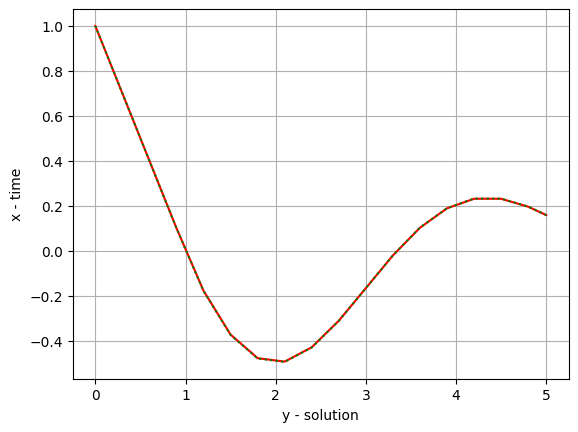

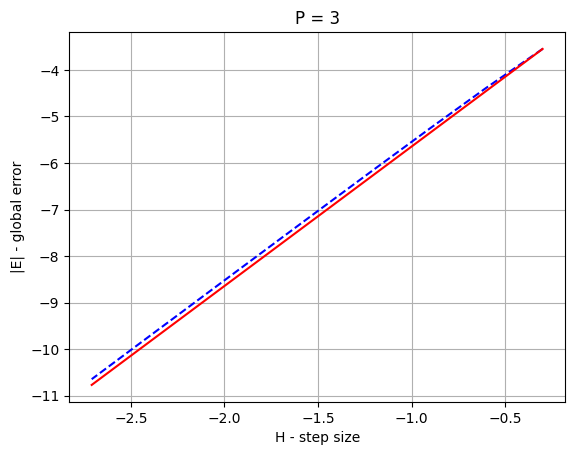

In [47]:
getGraph(CREK_method, problem1, H_1)
getGraph2Pow(CREK_method, problem1)

Err = 0.00010726106221503606


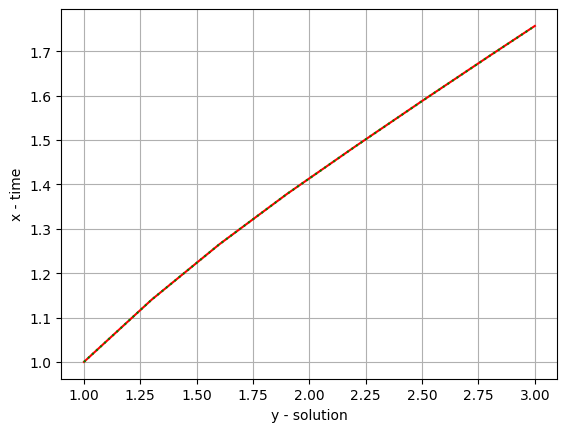

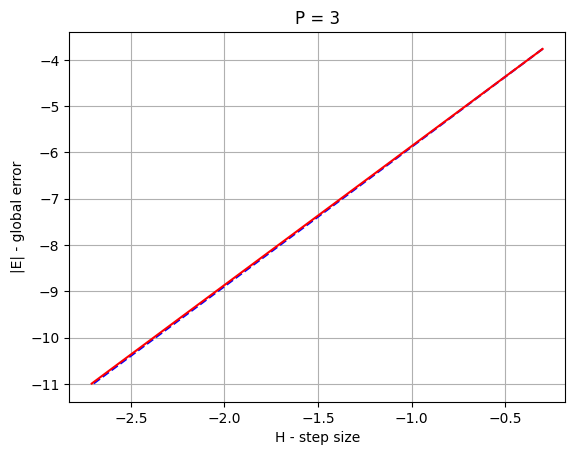

In [48]:
getGraph(CREK_method, problem2, H_2)
getGraph2Pow(CREK_method, problem2)

In [49]:
# Параметры метода Гаусса 2
A = [
        [1/4, (1 - 2/sqrt(3))/4],
        [(1 + 2/sqrt(3))/4, 1/4]
    ]

B = [
    lambda theta: (1 + sqrt(3)) * theta / 2 - sqrt(3) * theta * theta / 2,
    lambda theta: (1 - sqrt(3)) * theta / 2 + sqrt(3) * theta * theta / 2,
]

C = [(1 - 1/sqrt(3))/2, (1 + 1/sqrt(3))/2]

GAUSS2_implicit = Method(A, B, C, implict=True)

In [50]:
def solution3(x):
    return 3 * sin(x) - 5 * cos(x)
    
def f3(x, y, z):
    return y + z(x - np.pi) + 3 * cos(x) + 5 * sin(x)

def fprime3(x, y, z):
    return 1

def past3(x):
    return 3 * sin(x) - 5 * cos(x)

H_3 = 0.3

problem3 = Problem(x0 = 0, x1 = 2*np.pi, y0 = solution3(0), f = f3, trueSol = solution3, fprime = fprime3, past = past3, Z = Z)


In [51]:
# getGraph(GAUSS2_implicit, problem3, H_3)
# getGraph2Pow(GAUSS2_implicit, problem3, p = 4)

In [52]:
# Параметры метода Гаусса 3
A = [
    [5/36, 2/9 - sqrt(15)/15, 5/36 - sqrt(15)/30],
    [5/36 + sqrt(15)/24, 2/9, 5/36 - sqrt(15)/24],
    [5/36 + sqrt(15)/30, 2/9 + sqrt(15)/15, 5/36],
]
B = [
    lambda theta: 5/18, 
    lambda theta: 4/9, 
    lambda theta: 5/18
]
C = [
    1/2 - sqrt(15)/10, 
    1/2, 
    1/2 + sqrt(15)/10
]

GAUSS3_explicit = Method(A, B, C)

Err = 6.848863698394325e-10


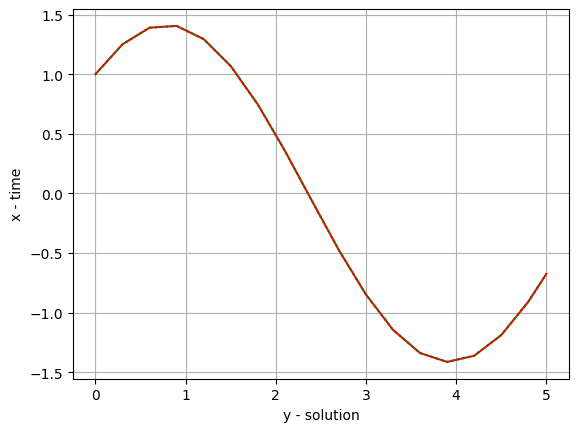

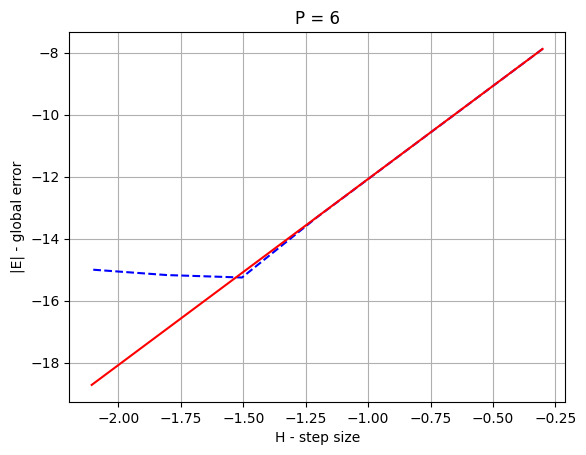

In [53]:
getGraph(GAUSS3_explicit, problem0, H_0)
getGraph2Pow(GAUSS3_explicit, problem0, p = 6, endPower=8)

In [54]:
# Параметры метода Гаусса 3

sq3by5over8 = sqrt(3/5) / 8

A = [
    [5/36, 2/9 - sqrt(15)/15, 5/36 - sqrt(15)/30],
    [5/36 + sqrt(15)/24, 2/9, 5/36 - sqrt(15)/24],
    [5/36 + sqrt(15)/30, 2/9 + sqrt(15)/15, 5/36],
]
B = [
    lambda theta: 10/9*theta**3 + (-5/3 - 1/6*sqrt(15))*theta**2 + theta*(5/6 + 1/6*sqrt(15)),
    lambda theta: -20/9*theta**3 + 10/3*theta**2 - 2/3*theta,
    lambda theta: 10/9*theta**3 + (-5/3 + 1/6*sqrt(15))*theta**2 + theta*(-1/6*sqrt(15) + 5/6)
]
C = [
    1/2 - sqrt(15)/10, 
    1/2, 
    1/2 + sqrt(15)/10
]

GAUSS3_implicit = Method(A, B, C, implict=True)

In [55]:
print([b(1) for b in B])
print([5/18, 4/9, 5/18])


[0.2777777777777777, 0.44444444444444453, 0.2777777777777779]
[0.2777777777777778, 0.4444444444444444, 0.2777777777777778]


Err = 6.848865918840374e-10


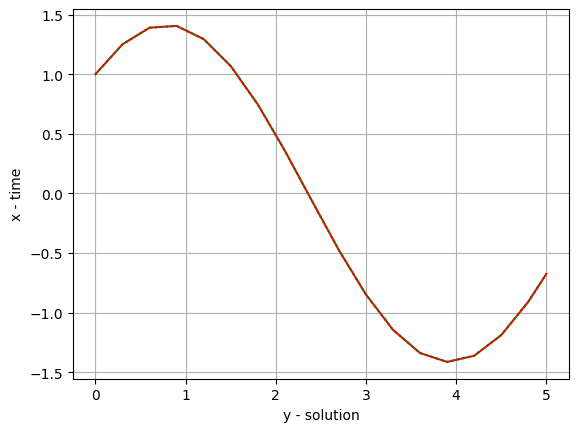

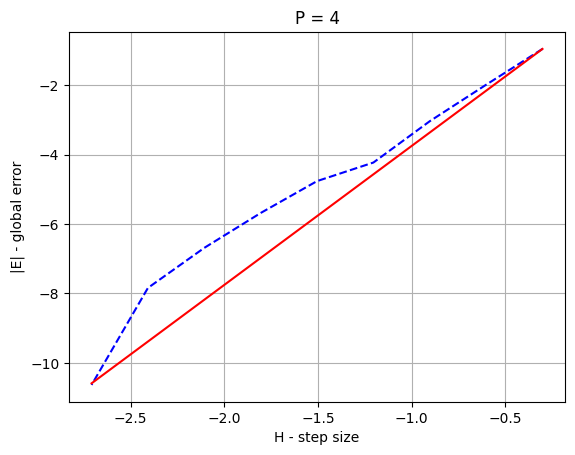

In [56]:
getGraph(GAUSS3_implicit, problem0, H_1)
getGraph2Pow(GAUSS3_implicit, problem3, p = 4, endPower = 10)

In [57]:
def solution4(x):
    return 4/13 * cos(3*x)+6/13*sin(3*x)+31/26*exp(-2*x)
    
def f4(x, y, z):
    return -2*(y - cos(3*x))


H_4 = 0.5

problem4 = Problem(x0 = 0, x1 = 3, y0 = solution4(0), f = f4, trueSol = solution4)

Err = 0.00014831649513158407


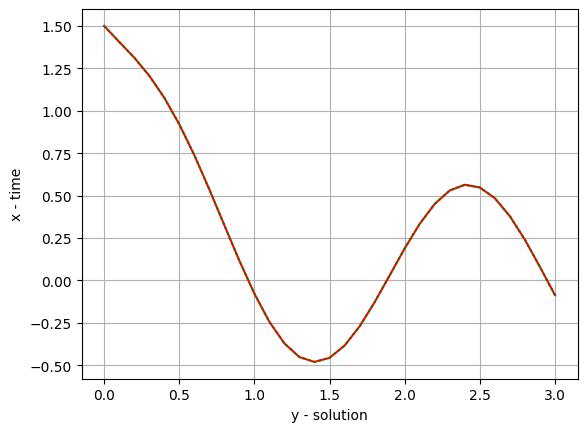

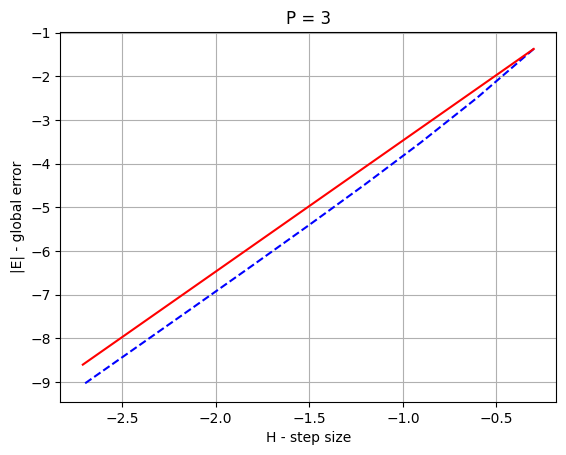

In [58]:
getGraph(CREK_method, problem4, 0.1, customX=[*np.arange(0, 3.1, 0.1)] )
getGraph2Pow(CREK_method, problem4, p = 3, endPower = 10)

Err = 4.101036817444337e-06


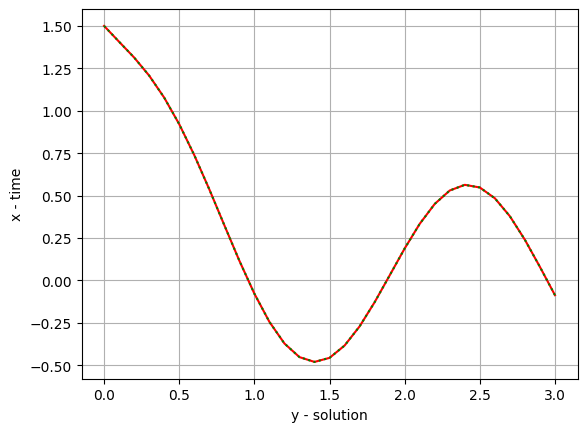

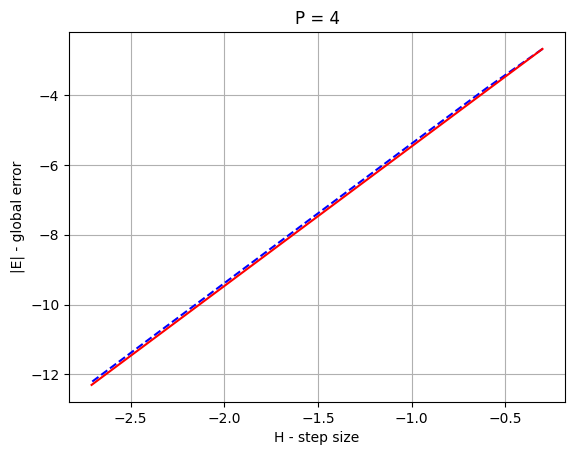

In [59]:
getGraph(GAUSS2_implicit, problem4, 0.1)
getGraph2Pow(GAUSS2_implicit, problem4, p = 4)

In [60]:
A = [
    [0, 0],
    [1/2, 0]
]

B = [
    lambda x: 0, 
    lambda x: 1/2
]

C = [
    0, 1/2
]

middlePoint = Method(A, B, C)

Err = 0.18954965355779915


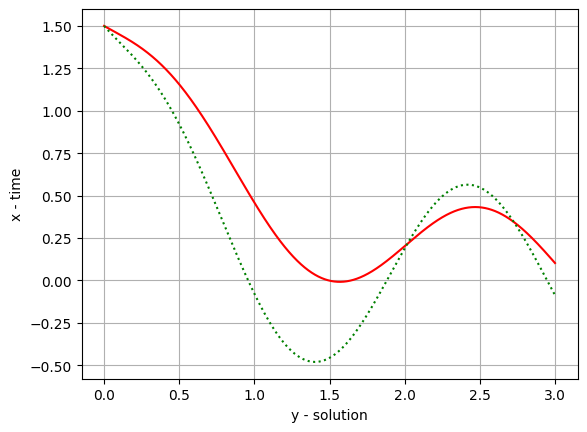

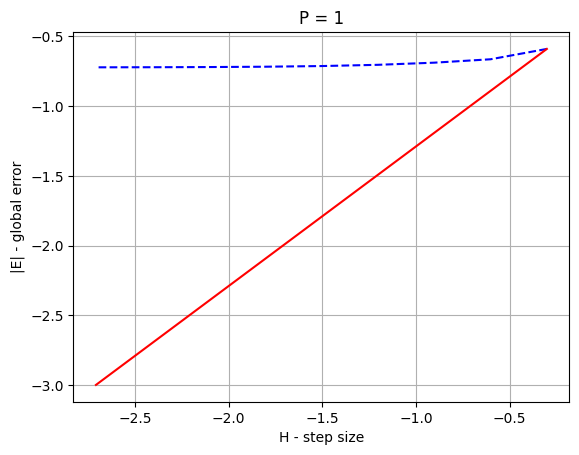

In [63]:
getGraph(middlePoint, problem4, 0.001)
getGraph2Pow(middlePoint, problem4, p = 1)